In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print('Last date {}'.format(last_date))

Last date ('2017-08-23',)


In [12]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print('Year ago {}'.format(year_ago))

Year ago 2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>year_ago).\
order_by(Measurement.date).all()
scores[0:10]

[('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0)]

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
scores_pd = pd.DataFrame(scores)
scores_pd=scores_pd.set_index('date')
scores_pd=scores_pd.sort_index()
scores_pd.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


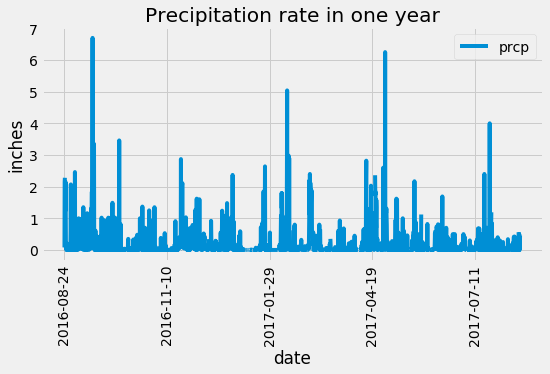

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
scores_pd.plot(figsize=(8,4))
plt.xticks(rotation='vertical')
plt.ylabel('inches')
plt.title('Precipitation rate in one year')
plt.savefig("../sql-alchemy-challenge/Images/precip1.png")
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
scores_pd.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
available_st = session.query(Measurement.station).distinct().count()
print('{} avaliable stations'.format(available_st))

9 avaliable stations


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_st = session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_st

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp = session.query(func.min(Measurement.tobs),
                    func.max(Measurement.tobs),
                    func.avg(Measurement.tobs)).filter(Measurement.station==active_st[0][0]).all()
print('Lowest temperature: {}.\nHighest temperature: {}\nAverage temperature: {}'.\
      format(temp[0][0],temp[0][1],round(temp[0][2],2)))

Lowest temperature: 54.0.
Highest temperature: 85.0
Average temperature: 71.66


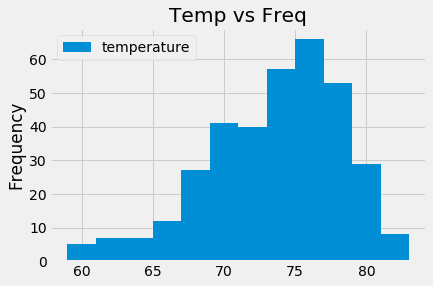

In [20]:
# Choose the station with the highest number of temperature observations.
most_station = session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).first()
most_tempst=most_station[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
observe = session.query(Measurement.tobs).filter(Measurement.date>=year_ago).\
filter(Measurement.station==most_tempst).all()
observe_pd = pd.DataFrame(observe,columns=['temperature'])

observe_pd.plot.hist(bins=12,title='Temp vs Freq')
plt.savefig("../sql-alchemy-challenge/Images/tempFreq.png")
plt.show()


## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp=calc_temps('2017-02-28','2017-03-05')
temp

[(64.0, 72.02777777777777, 78.0)]

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
#numpy's ravel func to manipulate with tuples
t_ravel=list(np.ravel(temp))
t_ravel

[64.0, 72.02777777777777, 78.0]

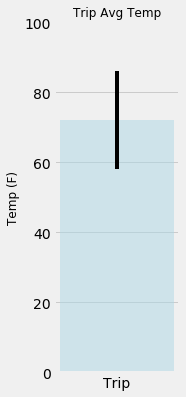

In [24]:
height=['Trip']
peak = t_ravel[2]-t_ravel[0]
plt.figure(figsize=(2,6))
plt.bar(height, t_ravel[1],yerr=peak,color='lightblue',alpha=0.5)
plt.ylim(0,100)
plt.ylabel('Temp (F)',fontsize=12)
plt.title('Trip Avg Temp',fontsize=12)
plt.grid(axis='x')
plt.savefig("../sql-alchemy-challenge/Images/tripTemp.png")
plt.show()

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_amount = session.query(Measurement.station,func.sum(Measurement.prcp),\
                            Station.name,Station.latitude,Station.longitude,\
                            Station.elevation).filter(Station.station==Measurement.station).\
filter(Measurement.date>='2017-02-28', Measurement.date<='2017-03-05').group_by(Measurement.station).\
order_by(func.sum(Measurement.prcp).desc()).all()
total_amount

[('USC00519281',
  4.720000000000001,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117', 4.45, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00516128',
  4.07,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00517948', 2.98, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00519397',
  2.7399999999999998,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00519523',
  2.32,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  1.1600000000000001,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0)]

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
start = '2017-02-28'
end = '2017-03-05'
# Use the start and end date to create a range of dates
dates = session.query(Measurement.date).filter(Measurement.date >= start).filter(Measurement.date<=end).\
group_by(Measurement.date).all()

dates = list(np.ravel(dates))

# Stip off the year and save a list of %m-%d strings
d_lst = []
for day in dates:
    d_lst.append(day[5:])

# Loop through the list of %m-%d strings and calculate the normals for each date
normal_lst=[]
for n in d_lst:
    normal_lst.append(list(np.ravel(daily_normals(n))))

print(20*'-')
print('Range of dates')
print(dates)
print(20*'-')
print('Only months and days')
print(d_lst)
print(20*'-')
print('Normals for each date')
normal_lst

--------------------
Range of dates
['2017-02-28', '2017-03-01', '2017-03-02', '2017-03-03', '2017-03-04', '2017-03-05']
--------------------
Only months and days
['02-28', '03-01', '03-02', '03-03', '03-04', '03-05']
--------------------
Normals for each date


[[65.0, 70.65517241379311, 80.0],
 [64.0, 70.0327868852459, 76.0],
 [61.0, 70.36666666666666, 78.0],
 [60.0, 70.06896551724138, 78.0],
 [57.0, 69.27272727272727, 77.0],
 [60.0, 67.89090909090909, 76.0]]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_pd = pd.DataFrame(normal_lst)
dates_pd = pd.DataFrame(dates)
ranges_pd = pd.merge(normals_pd,dates_pd,right_index=True,left_index=True)
ranges_pd.rename(columns={'0_x':'MinTemp',
                         1:'AvgTemp',
                         2:'MaxTemp',
                         '0_y':'Date'},inplace=True)
ranges_pd.set_index('Date',inplace=True)
ranges_pd


,MinTemp,AvgTemp,MaxTemp
Date,,,
2017-02-28,65.0,70.655172,80.0
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0
2017-03-05,60.0,67.890909,76.0


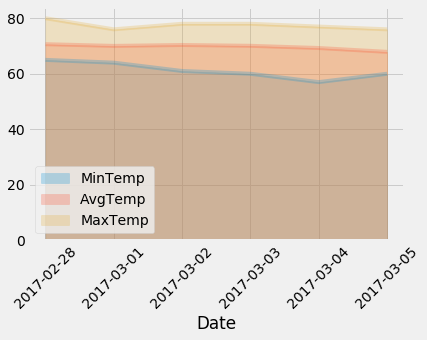

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
ranges_pd.plot.area(stacked=False,alpha=0.25)
plt.xticks(rotation=45)
plt.savefig('../sql-alchemy-challenge/Images/stacked.png')
plt.show()